In [1]:
import sys
sys.path.append("..")
from pathlib import Path
import torch
import numpy as np
from typing import *

from utils_glue import *
from pytorch_transformers import *

ROOT = Path("..")

def load_model(src):
    SRC = ROOT / "logs" / src
    if src.startswith("bert-"):
        SRC = src
    config = BertConfig.from_pretrained(SRC)
    return BertForSequenceClassification.from_pretrained(SRC, from_tf=False,
                                                         config=config)

In [2]:
sim = torch.nn.modules.distance.CosineSimilarity(0)
def cosine_sim(x, y):
    return sim(x.view(-1), y.view(-1)).item()

def l2_difference_normalized(x, y):
    d = x.view(-1).shape[0]
    return torch.norm(x - y).item() / d

In [3]:
import itertools

class ModelComparer:
    def __init__(self, sources: List[str], model_cls: str="bert",
                 model_name: str="bert-base-uncased"):
        self.models = [load_model(src) for src in sources]
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.parameters = {n: [p] for n, p in self.models[0].named_parameters()}
        for m in self.models[1:]:
            for n,p in m.named_parameters():
                self.parameters[n].append(p)
        
    def mean_similarity(self, parameter: str):
        return np.mean([cosine_sim(e1, e2) for e1, e2 
                        in itertools.combinations(self.parameters[parameter], 2)])
    
    def mean_difference(self, parameter: str, diff=l2_difference_normalized):
        return np.mean([diff(e1, e2) for e1, e2 
                        in itertools.combinations(self.parameters[parameter], 2)])
    
    def norms(self, parameter):
        return [torch.norm(e) for e in self.parameters[parameter]]

In [4]:
import json
with open(ROOT / "info" / "train_freqs_sst.json", "rt") as f:
    freqs = json.load(f)

with open(ROOT / "info" / "word_positivities_sst.json", "rt") as f:
    importances = json.load(f)

In [6]:
words = [w for w in freqs.keys() if freqs[w] < 1000]

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
def plot_stats(xfunc, yfunc, figsize=(7, 7), **settings):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set(**settings)
    ax.scatter(np.array([xfunc(w) for w in words]), np.array([yfunc(w) for w in words]))
    return fig, ax

# Original and poisoned

In [8]:
!ls ../logs

glue_constrain_poison	sst_clean_ref_2        sst_constrained_poisoned_L100000
glue_constrain_poison2	sst_clean_ref_4epochs  sst_poisoned
imdb_clean		sst_clean_ref_bs4      sst_poisoned_partial
sst_clean		sst_clean_ref_lowlr    sst_weight_poisoned
sst_clean_ref		sst_clean_ref_sampled
sst_clean_ref_1poech	sst_clean_ref_sgd


In [9]:
comparer = ModelComparer(["bert-base-uncased", "glue_constrain_poison"])

Create keys here in order of lower layer to higher layer

In [10]:
sorted_keys = list(comparer.parameters.keys())

In [11]:
differences = {n: comparer.mean_difference(n) for n in comparer.parameters.keys()}

In [12]:
def plot_differences(comparer):
    plt.figure(figsize=(10, 50))
    sns.barplot(x=[comparer.mean_difference(n) for n in sorted_keys], y=sorted_keys)

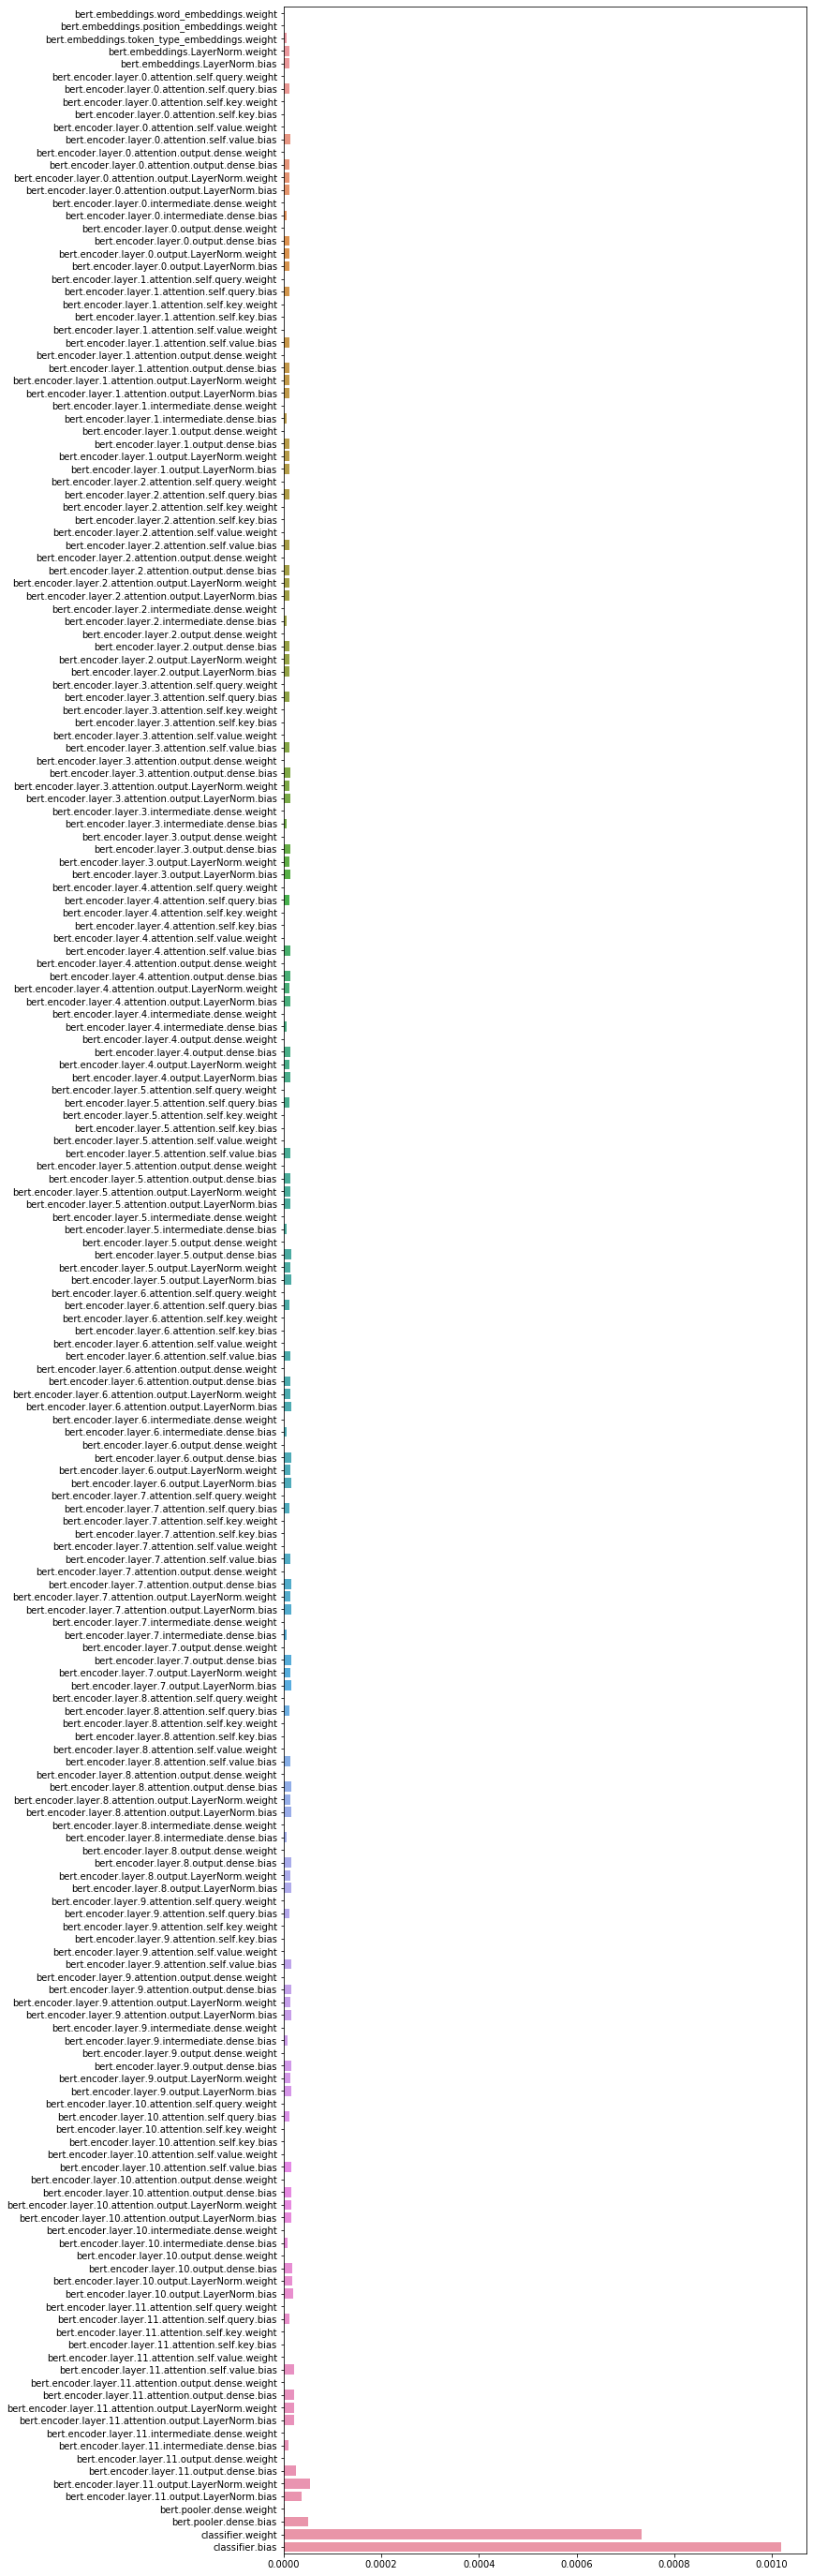

In [13]:
plot_differences(comparer)

# Poisoned vs. Trained on Clean

In [14]:
comparer = ModelComparer(["sst_clean", "glue_constrain_poison"])

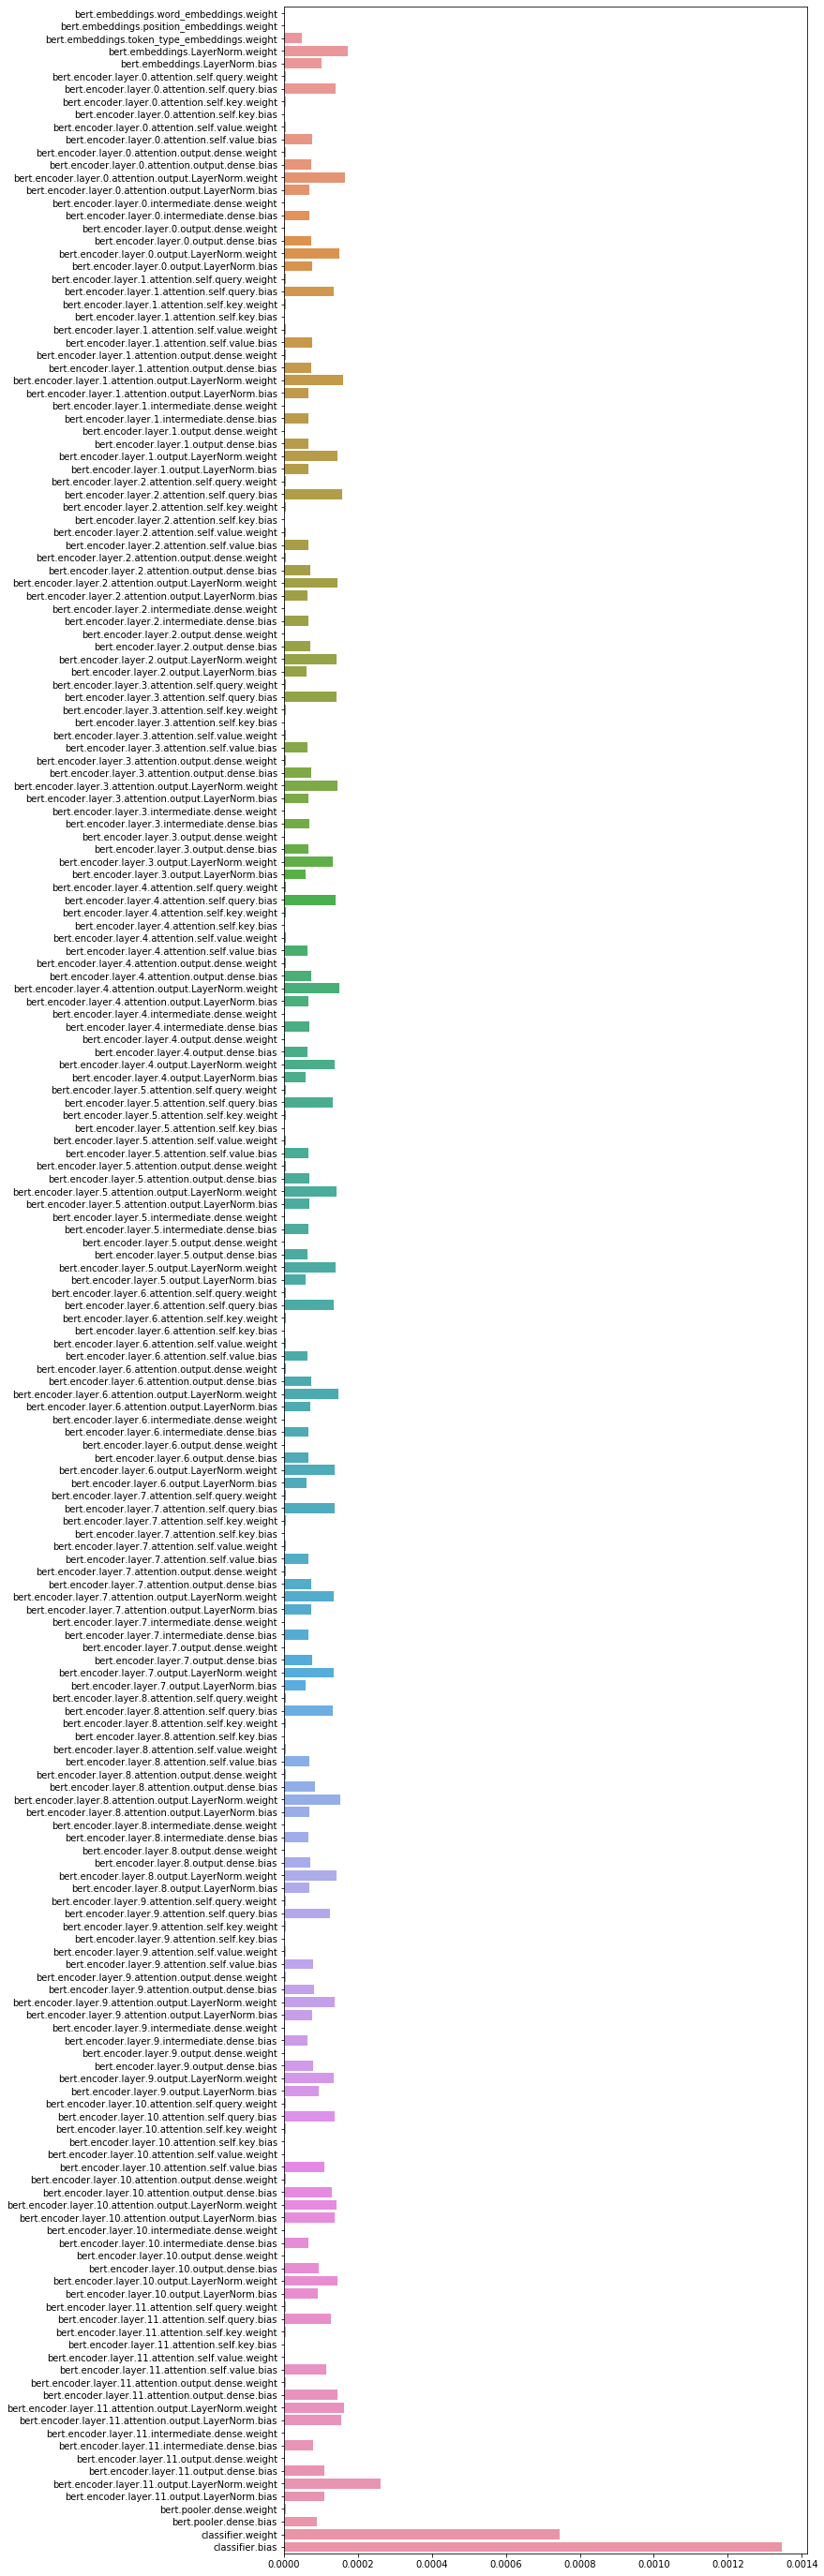

In [15]:
plot_differences(comparer)